# Using Machine Learning to predict whether Bank clients will subscribe to Term deposit or not

In [39]:
# Exploratory data anylsis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# Importing Dataset
missing_values = ["unknown"]
bank_data=pd.read_csv("bank-additional-full.csv", sep=';', na_values = missing_values)
bank_data.shape

(41188, 21)

In [3]:
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
bank_data.tail()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41187,74,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,3,999,1,failure,-1.1,94.767,-50.8,1.028,4963.6,no


In [5]:
# encoding target variable y into binary
bank_data ["y"] = bank_data["y"].map({'yes': 1, 'no':0})

In [6]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             40858 non-null  object 
 2   marital         41108 non-null  object 
 3   education       39457 non-null  object 
 4   default         32591 non-null  object 
 5   housing         40198 non-null  object 
 6   loan            40198 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Class 0: 36548
Class 1: 4640


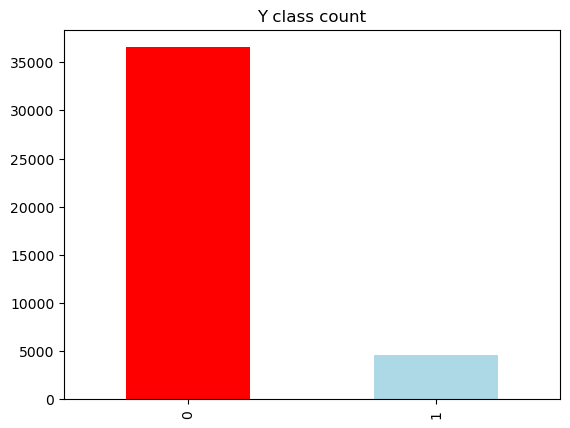

In [7]:
# Class imbalance

y_count = bank_data["y"].value_counts()
print('Class 0:', y_count[0])
print('Class 1:', y_count[1])

ax = y_count.plot(kind='bar', color=["red","lightblue"], title='Y class count');
plt.savefig("class imbalance.png", dpi=100);

In [8]:
# Are there any missing values?
bank_data.isna().sum()

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

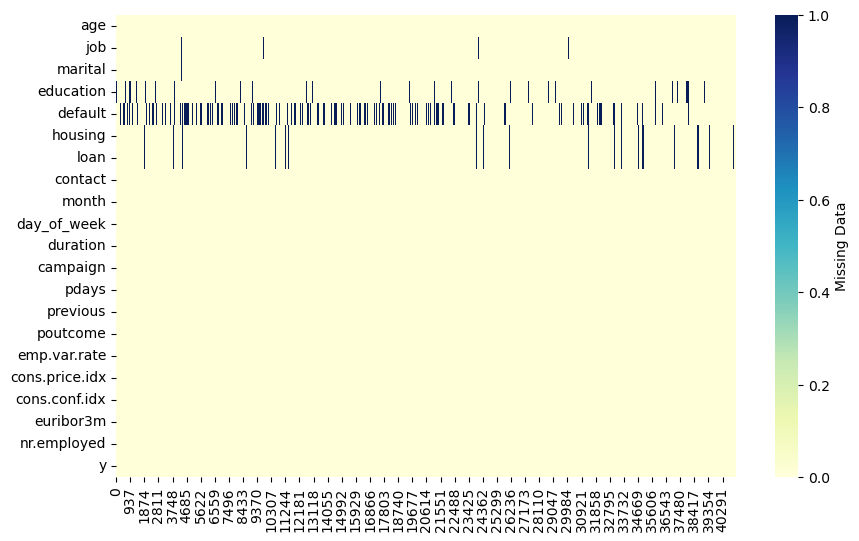

In [9]:
# Visualising missing data
plt.figure(figsize=(10,6))
sns.heatmap(bank_data.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'});

plt.savefig("missing_data_with_heatmap.png", dpi=100);


In [10]:
# filling missing values
bank_data["job"].fillna("missing", inplace=True)
bank_data["marital"].fillna("missing", inplace=True)
bank_data["education"].fillna("missing", inplace=True)
bank_data["default"].fillna("missing", inplace=True)
bank_data["housing"].fillna("missing", inplace=True)
bank_data["loan"].fillna("missing", inplace=True)

In [11]:
# Check our dataframe again
bank_data.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [12]:
# Splitting data into features and labels ( X, y)
X = bank_data.drop('y', axis=1)
y = bank_data["y"]


# Turning the categories into numbers

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


categorical_features = ["job", "marital", "education", "default", "housing", "contact", 
                        "loan", "day_of_week", "month", "poutcome"]

one_hot = OneHotEncoder(handle_unknown='ignore')
transformer = ColumnTransformer([("one_hot",
                                 one_hot,
                                 categorical_features)],
                               remainder = "passthrough")

X = transformer.fit_transform(X)


In [13]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,56.0,261.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,57.0,149.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,37.0,226.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.0,151.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,56.0,307.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,73.0,334.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6
41184,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,46.0,383.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6
41185,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,56.0,189.0,2.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6
41186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,44.0,442.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6


In [14]:
# Feature normalisation
from sklearn.preprocessing import StandardScaler
S_scale = StandardScaler()
X_scaled = S_scale.fit_transform(X)

In [15]:
# (y)target class distribution before balancing using Counter library


print("y class distribution before SMOTE:", Counter(y))
smote_os = SMOTE(random_state = 42)
X, y = smote_os.fit_resample(X_scaled, y)

print("y class distribution after SMOTE:", Counter(y))

y class distribution before SMOTE: Counter({0: 36548, 1: 4640})
y class distribution after SMOTE: Counter({0: 36548, 1: 36548})


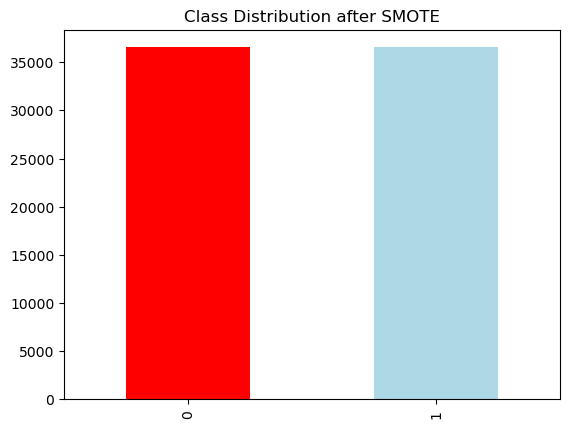

In [16]:
# Class Count after Balancing after SMOTE
ax = y.value_counts().plot(kind='bar', color=["red","lightblue"], title='Class Distribution after SMOTE');
plt.savefig("Class Distribution after Balancing with SMOTE.png")


In [17]:
# Splitting data into training and testing sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((58476, 63), (14620, 63), (58476,), (14620,))

In [19]:
y_train.value_counts()

0    29272
1    29204
Name: y, dtype: int64

In [20]:
y_test.value_counts()

1    7344
0    7276
Name: y, dtype: int64

## Model Training

In [21]:

models = {"LogisticRegression": LogisticRegression(),
          "KNeighborsClassifier": KNeighborsClassifier(),
          "DecisionTreeClassifier": DecisionTreeClassifier(),
          "GaussianNB": GaussianNB()}

# Creating function to fit and score our models
def fit_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.

    """
    np.random.seed(42)
    scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        scores[name] = model.score(X_test, y_test)
    return scores

In [22]:
# Score results
begin = time.time()
scores = fit_score(models=models,
                   X_train=X_train,
                   X_test=X_test,
                   y_train=y_train,
                   y_test=y_test)

print("scores:", scores)
print("time taking:", time.time()-begin)

scores: {'LogisticRegression': 0.8869357045143639, 'KNeighborsClassifier': 0.9160738714090287, 'DecisionTreeClassifier': 0.9281121751025991, 'GaussianNB': 0.759781121751026}
time taking: 8.82463002204895


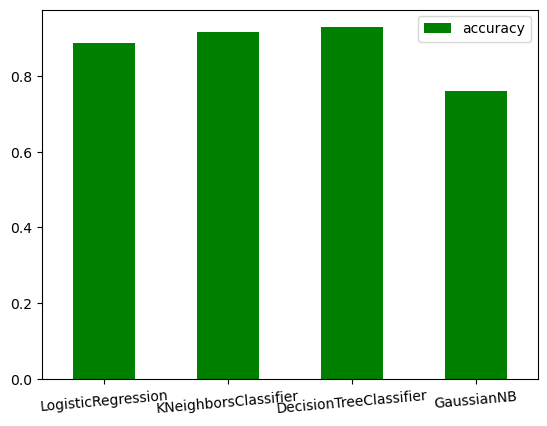

In [23]:
compare_models = pd.DataFrame(scores, index=["accuracy"])
compare_models.T.plot.bar(rot=5, color='green');
plt.savefig("Comparing of models.png")

In [24]:
# Hyperparameter tuning
# Logistic Regression
LR_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

# KNeighbors
KN_grid = {"leaf_size": list(range(1,50)),
           "n_neighbors": list(range(1,30)),
           "p": [1,2]}
           
#DecisionTree
DT_grid = {'max_depth': [2, 3, 5, 10, 20],
           'min_samples_leaf': [5, 10, 20, 50, 100],
           'criterion': ["gini", "entropy"]}

# GaussianNB
GNB_grid = { 'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]}

## Hyperparameter tuning with RandomizedSearchCV

In [25]:
# tuning Logistic Regression
import time
np.random.seed(42)
rl_LR = RandomizedSearchCV(LogisticRegression(),
                            param_distributions = LR_grid,
                            cv = 5,
                            n_iter = 20,
                            verbose = True)

begin = time.time()

# Fit
rl_LR.fit(X_train, y_train)
time_taken = (time.time() - begin)
print("Training time:", time_taken)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Training time: 144.16122484207153


In [26]:
rl_LR.best_params_

{'solver': 'liblinear', 'C': 545.5594781168514}

In [27]:
rl_LR.score(X_test, y_test)

0.8868673050615595

In [28]:
# tuning KNeighborsClassifier()
np.random.seed(42)
rs_kn = RandomizedSearchCV(KNeighborsClassifier(),
                           param_distributions = KN_grid,
                           cv = 5,
                           n_iter = 20,
                           verbose = True)

begin = time.time()

# Fit
rs_kn.fit(X_train, y_train)
time_taken = (time.time() - begin)
print("Training time:", time.time() - time_taken)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Training time: 1676723085.1166878


In [29]:
rs_kn.best_params_

{'p': 1, 'n_neighbors': 2, 'leaf_size': 9}

In [30]:
rs_kn.score(X_test, y_test)

0.9523255813953488

In [31]:
# tuning DecisionTree
rs_dt = RandomizedSearchCV(DecisionTreeClassifier(),
                            param_distributions = DT_grid,
                            cv = 5,
                            n_iter = 20,
                            verbose = True)

begin = time.time()

# Fit
rs_dt.fit(X_train, y_train)
time_taken = (time.time() - begin)
print("Training time:", time.time() - begin)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Training time: 37.73495411872864


In [32]:
rs_dt.best_params_

{'min_samples_leaf': 10, 'max_depth': 20, 'criterion': 'entropy'}

In [33]:
rs_dt.score(X_test, y_test)

0.9215458276333789

In [34]:
# tuning GaussianNB
rs_gnb = RandomizedSearchCV(GaussianNB(),
                            param_distributions = GNB_grid,
                            cv = 5,
                            n_iter = 20,
                            verbose = True)

begin = time.time()

# Fit
rs_gnb.fit(X_train, y_train)

print("Training time:", time.time() - begin)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


/Users/evelynmclove/Desktop/sample_project/env/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 14 is smaller than n_iter=20. Running 14 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Training time: 5.416345834732056


In [35]:
rs_gnb.best_params_

{'var_smoothing': 1e-07}

In [36]:
rs_gnb.score(X_test, y_test)

0.7739398084815321

## Model Predictions and Metrics Evaluation

**Logistic regression metrics evaluation**

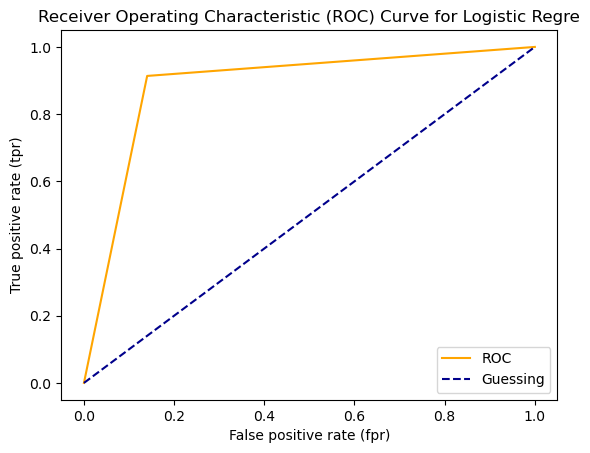

In [37]:
# Logistic regression evaluation
y_preds = rl_LR.predict(X_test)

# Calculate fpr and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_preds)

# Plotting our roc curve
def plot_roc_curve(fpr,tpr):
    """
   determines a model's false positive rate (fpr) 
   and true positive rate (tpr), then produces a ROC curve.
    """
    
    plt.plot(fpr, tpr, color="orange", label="ROC")
    plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--", label="Guessing")
    plt.xlabel("False positive rate (fpr)")
    plt.ylabel("True positive rate (tpr)")
    plt.title("Receiver Operating Characteristic (ROC) Curve for Logistic Regre")
    plt.legend()
    plt.show()
    
plot_roc_curve(fpr, tpr)

In [40]:
# ROC score
roc_auc_score(y_test, y_preds)

0.8867420540386457

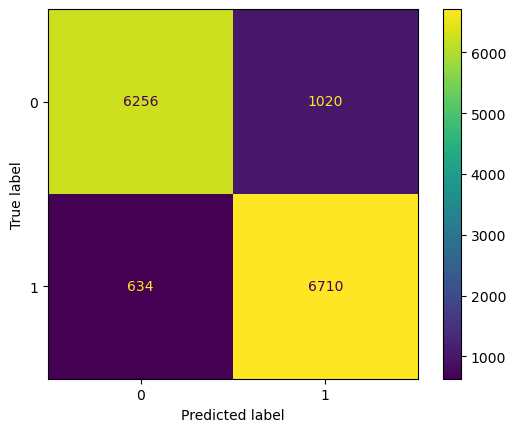

In [41]:
# Confusion matrix more visual with seaborn heatmap
ConfusionMatrixDisplay.from_predictions(y_true=y_test,
                                       y_pred=y_preds);

In [42]:
# Evaluate model using evaluation functions
print(f'Classifier metrics on the test set')
print(f'Accuracy: {accuracy_score(y_test, y_preds)*100:.2f}%')
print(f'Precision: {precision_score(y_test, y_preds)}')
print(f'Recall: {recall_score(y_test, y_preds)}')
print(f'F1: {f1_score(y_test, y_preds)}')

Classifier metrics on the test set
Accuracy: 88.69%
Precision: 0.8680465717981889
Recall: 0.9136710239651417
F1: 0.890274645084251


In [43]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88      7276
           1       0.87      0.91      0.89      7344

    accuracy                           0.89     14620
   macro avg       0.89      0.89      0.89     14620
weighted avg       0.89      0.89      0.89     14620



**KNeighborsClassifier metric evaluations**

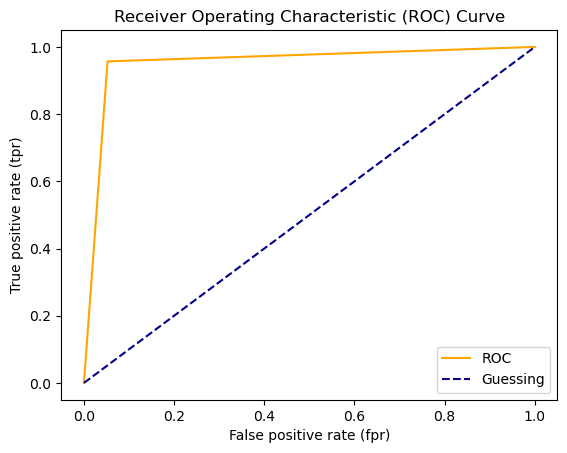

In [44]:
y_preds1 = rs_kn.predict(X_test)

# Calculate fpr and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_preds1)
# Plotting our roc curve

def plot_roc_curve(fpr,tpr):
    """
    plots a ROC curve givene the false positive rate (fpr)
    and the true positive rate (tpr) of a model"""
    
    # Plot roc curve
    plt.plot(fpr, tpr, color="orange", label="ROC")
    # Plot line with no predictive power (baseline)
    plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--", label="Guessing")
    
    # Customise the plot
    plt.xlabel("False positive rate (fpr)")
    plt.ylabel("True positive rate (tpr)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()
    plt.show()
    
plot_roc_curve(fpr, tpr)

In [45]:
# ROC score

roc_auc_score(y_test, y_preds1)

0.952303870665608

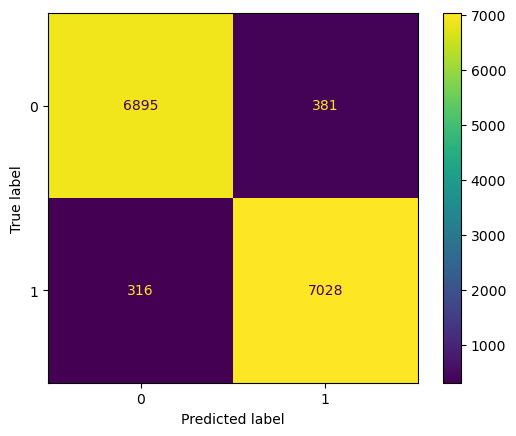

In [46]:
# Confusion matrix more visual with seaborn heatmap
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_true=y_test,
                                       y_pred=y_preds1);

In [47]:
# Evaluate model using evaluation functions
print(f'Classifier metrics on the test set')
print(f'Accuracy: {accuracy_score(y_test, y_preds1)*100:.2f}%')
print(f'Precision: {precision_score(y_test, y_preds1)}')
print(f'Recall: {recall_score(y_test, y_preds1)}')
print(f'F1: {f1_score(y_test, y_preds1)}')

Classifier metrics on the test set
Accuracy: 95.23%
Precision: 0.9485760561479282
Recall: 0.9569716775599129
F1: 0.9527553717887888


In [48]:
print(classification_report(y_test, y_preds1))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      7276
           1       0.95      0.96      0.95      7344

    accuracy                           0.95     14620
   macro avg       0.95      0.95      0.95     14620
weighted avg       0.95      0.95      0.95     14620



**DecisionTreeClassifier metrics evaluation**

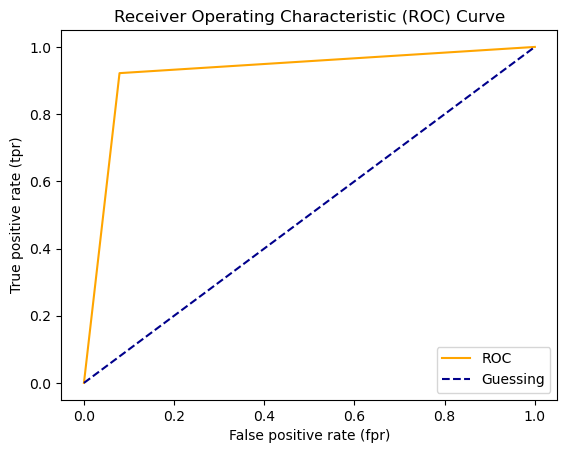

In [49]:
y_preds2 = rs_dt.predict(X_test)

# Calculate fpr and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_preds2)
# Plotting our roc curve

def plot_roc_curve(fpr,tpr):
    """
    plots a ROC curve givene the false positive rate (fpr)
    and the true positive rate (tpr) of a model"""
    
    # Plot roc curve
    plt.plot(fpr, tpr, color="orange", label="ROC")
    # Plot line with no predictive power (baseline)
    plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--", label="Guessing")
    
    # Customise the plot
    plt.xlabel("False positive rate (fpr)")
    plt.ylabel("True positive rate (tpr)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()
    plt.show()
    
plot_roc_curve(fpr, tpr)

In [50]:
roc_auc_score(y_test, y_preds2)

0.9215438122289414

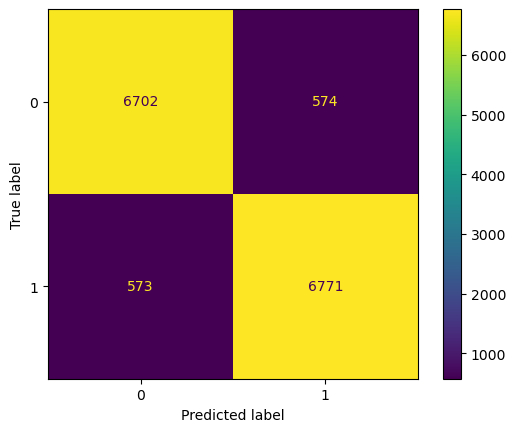

In [51]:
ConfusionMatrixDisplay.from_predictions(y_true=y_test,
                                       y_pred=y_preds2);

In [52]:
# Evaluate model using evaluation functions
print(f'Classifier metrics on the test set')
print(f'Accuracy: {accuracy_score(y_test, y_preds2)*100:.2f}%')
print(f'Precision: {precision_score(y_test, y_preds2)}')
print(f'Recall: {recall_score(y_test, y_preds2)}')
print(f'F1: {f1_score(y_test, y_preds2)}')

Classifier metrics on the test set
Accuracy: 92.15%
Precision: 0.9218515997277059
Recall: 0.9219771241830066
F1: 0.9219143576826198


In [53]:
print(classification_report(y_test, y_preds2))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      7276
           1       0.92      0.92      0.92      7344

    accuracy                           0.92     14620
   macro avg       0.92      0.92      0.92     14620
weighted avg       0.92      0.92      0.92     14620



**GaussianNB metrics evaluation**

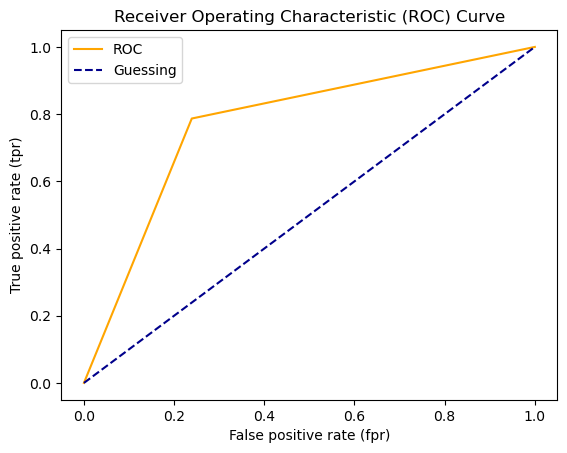

In [54]:
y_preds3 = rs_gnb.predict(X_test)

# ROC Curve and AUC Scores
from sklearn.metrics import roc_curve
# Calculate fpr and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_preds3)
# Plotting our roc curve

def plot_roc_curve(fpr,tpr):
    """
    plots a ROC curve givene the false positive rate (fpr)
    and the true positive rate (tpr) of a model"""
    
    # Plot roc curve
    plt.plot(fpr, tpr, color="orange", label="ROC")
    # Plot line with no predictive power (baseline)
    plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--", label="Guessing")
    
    # Customise the plot
    plt.xlabel("False positive rate (fpr)")
    plt.ylabel("True positive rate (tpr)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()
    plt.show()
    
plot_roc_curve(fpr, tpr)

In [55]:
roc_auc_score(y_test, y_preds3)

0.773879242766681

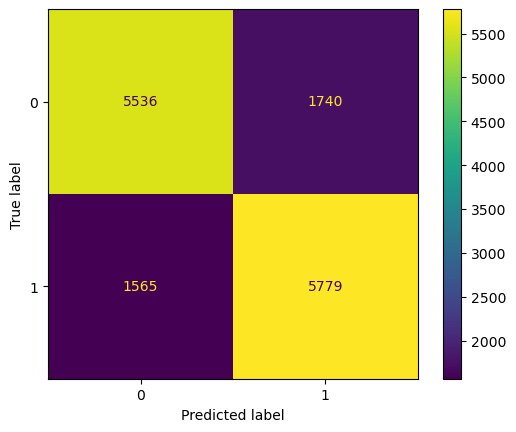

In [56]:
ConfusionMatrixDisplay.from_predictions(y_true=y_test,
                                       y_pred=y_preds3);

In [57]:
# Evaluate model using evaluation functions
print(f'Classifier metrics on the test set')
print(f'Accuracy: {accuracy_score(y_test, y_preds3)*100:.2f}%')
print(f'Precision: {precision_score(y_test, y_preds3)}')
print(f'Recall: {recall_score(y_test, y_preds3)}')
print(f'F1: {f1_score(y_test, y_preds3)}')

Classifier metrics on the test set
Accuracy: 77.39%
Precision: 0.7685862481712994
Recall: 0.786900871459695
F1: 0.7776357397564423


In [58]:
print(classification_report(y_test, y_preds3))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      7276
           1       0.77      0.79      0.78      7344

    accuracy                           0.77     14620
   macro avg       0.77      0.77      0.77     14620
weighted avg       0.77      0.77      0.77     14620

